In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp2d
import xarray as xr
import toolz

In [2]:
!git rev-parse HEAD
!git status

25297f485ce5115aadf225837e6de7a782254a21
On branch master
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   ../Snakefile
	new file:   ../snakemake/regrid.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	1.0-ndb-interpolate-regular-grid.ipynb



In [3]:
rb = xr.open_dataset("../data/raw/rayben/10ksamples.nc", chunks={'t': 1})

In [4]:
x = np.asarray(rb.x)

remove the indices where the distance is 0

In [5]:
xind, = np.nonzero(np.diff(x) > 1e-10)

rb = rb.isel(x=xind)

x = np.asarray(rb.x)
z = np.asarray(rb.z)


data = np.asarray(rb.uY.isel(t=0))

What is the difference in the grid spacing

In [6]:
np.diff(x).min(), np.diff(x).max()

(0.0036952496, 0.049865007)

In [7]:
np.diff(z).min(), np.diff(z).max()

(0.0036955329, 0.049864739)

This is a pretty radical difference. Let's just use 64 grid points total in the vertical, and 512 in the horizontal in the regridded data.

In [8]:
nx, nz = 512, 64

xg = np.linspace(0, x.max(), nx, endpoint=False)
zg = np.linspace(0, z.max(), nz, endpoint=False)

In [9]:
%timeit interp2d(x,z,data)(xg, zg)

1.03 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


this interpolation is pretty fast, so there is no need to improve the code further 

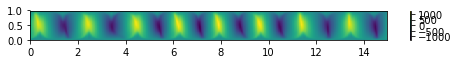

In [10]:
interpolated_data = interp2d(x,z,data)(xg, zg)

plt.figure(figsize=(8, 8/15))
ax = plt.pcolormesh(xg, zg, interpolated_data)
plt.colorbar()

## Code for automatic this task

In [11]:
def get_regular_grid(nx, nz):
    xg = np.linspace(0, 15.0, nx, endpoint=False)
    zg = np.linspace(0, 1.0, nz, endpoint=False)
    
    return xg, zg

@toolz.curry
def interpolate_data(x, z, xg, zg, data):
    
    return interp2d(x, z, data[0,:,:])(xg, zg)[np.newaxis,:,:]

def remove_duplicate_x(ds):
    x = np.asarray(ds.x)
    xind, = np.nonzero(np.diff(x) > 1e-10)
    return ds.isel(x=xind)



def regrid_dataarray(xarr):

    ds_deduped = remove_duplicate_x(xarr)
    darr = ds_deduped.data

    x = np.asarray(ds_deduped.x)
    z = np.asarray(ds_deduped.z)

    xg, zg = get_regular_grid(512, 64)


    interpolater = interpolate_data(x, z, xg, zg)
    # map_blocks
    darr_interp = darr.map_blocks(interpolater, dtype=darr.dtype, chunks=(1, len(zg), len(xg)))
    out_xarr = xr.DataArray(darr_interp, coords={'x': xg, 'z': zg, 't': ds_deduped['t']}, dims=['t','z','x'])
    
    return out_xarr

def regrid_dataset(ds):
    return ds.apply(regrid_dataarray)

rb_rg = regrid_dataset(rb)

In [12]:
rb_rg

<xarray.Dataset>
Dimensions:  (t: 10000, x: 512, z: 64)
Coordinates:
  * x        (x) float64 0.0 0.0293 0.05859 0.08789 0.1172 0.1465 0.1758 ...
  * z        (z) float64 0.0 0.01562 0.03125 0.04688 0.0625 0.07812 0.09375 ...
  * t        (t) int32 10001 10002 10003 10004 10005 10006 10007 10008 10009 ...
Data variables:
    uY       (t, z, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    uX       (t, z, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    T        (t, z, x) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...

This code is ready to refactor!